<h1 align='center'>Distribution of LDA topics</h1>

In this notebook we have a closer look at the topics we computed with the LDA algorithm and analyze their popularity across different countries and over time
<hr>

In [15]:
from gensim import corpora, models, similarities, matutils
import itertools
import numpy as np
import pandas as pd
from unidecode import unidecode
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

In [16]:
dropbox = "/Users/mr/Dropbox/moviemeta/"

In [55]:
imdb_topic_labels ={0:'magic, myths',
                    1:'school, college',
                    2:'fantasy, christmas',
                    3:'home', 
                    4:'ships, sailing, pirates',
                    5:'love, relationships',
                    6:'war', 
                    7:'exploration, nature, space', 
                    8:'comedy',
                    9:'places, nature, scenery',
                    10:'hollywood, stars', 
                    11:'society, culture',
                    12:'historical, costumes', 
                    13:'money, robbery',
                    14:'photography, design',
                    15:'spies, terrorism', 
                    16:'mixed', 
                    17:'town',
                    18:'press, politics',
                    19:'crime, police, underworld',
                    20:'documentary, interview',
                    21:'friendship, relationships',
                    22:'cowboys and indians',
                    23:'night life, enjoyment',
                    24:'crime, mistery', 
                    25:'music',
                    26:'farming, country side',
                    27:'fantasy, fairy tale',
                    28:'love, family', 
                    29:'gangs, drugs, police'}

## LDA topic distribution for IMDB data

In [244]:
imdb_lda = models.LdaModel.load(dropbox +'lda_imdb.model')
imdb_corpus = corpora.MmCorpus(dropbox +'lda_imdb.corpus')
imdb_dict = corpora.Dictionary.load(dropbox +'lda_imdb.dict')
imdb_meta_df = pd.read_csv(dropbox + 'imdb_meta_df_cleaned.csv')
imdb_topic_matrix = matutils.corpus2dense(imdb_lda[imdb_corpus], num_terms=30, num_docs=len(imdb_corpus))
imdb_topic_df = pd.DataFrame(np.ndarray.transpose(imdb_topic_matrix))
imdb_topic_df = pd.concat([imdb_topic_df, imdb_meta_df], axis=1) 
imdb_topic_df.to_csv(dropbox + 'imdb_topic_df.csv')
imdb_topic_df = pd.read_csv(dropbox + 'imdb_topic_df.csv')
imdb_topic_df = imdb_topic_df.set_index('Unnamed: 0').drop('Unnamed: 0.1', axis=1)

Now we have created a dataframe with the topic distribution for every movie. We have 30 topics, columns 0 - 29. The values represent how prominently a topic features in a movie.

In [245]:
imdb_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,title,year
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0.000000,0.096385,0,0.000000,0,0,...,0,0.000000,0.659350,0.000000,0.000000,0.000000,0,0,#1 Serial Killer (2013),2013
4,0,0,0,0,0.037337,0.000000,0,0.800602,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,#29 (2012),2012
5,0,0,0,0,0.000000,0.000000,0,0.000000,0,0,...,0,0.000000,0.229568,0.000000,0.000000,0.069438,0,0,#30 (2013),2013
7,0,0,0,0,0.000000,0.291638,0,0.290491,0,0,...,0,0.000000,0.000000,0.035633,0.030289,0.000000,0,0,#47 (2014),2014
8,0,0,0,0,0.000000,0.000000,0,0.516517,0,0,...,0,0.223738,0.000000,0.107120,0.000000,0.000000,0,0,#5 (2013),2013


### Add countries of origin 

We create a data frame of all movies since 2007 and add the countries of origin fram the IMDB data set. 

In [197]:
imdb_meta_2007_2015 = imdb_meta_df[imdb_meta_df.year > 2006]

with open(dropbox + "imdb/countries.list") as f:
    countries = f.readlines()
    
imdb_meta_2007_2015['origin'] = pd.Series(index=imdb_meta_2007_2015.index)
for i,movie in enumerate(countries):
    if movie[0] == '"':
        continue
    split = movie.split('\t')
    title = split[0]
    idx = imdb_meta_2007_2015[imdb_meta_2007_2015['title']== title].index
    #if the title is in our dataframe add the country
    if len(idx > 0):
        imdb_meta_2007_2015.loc[[idx[0]],['origin']]= split[len(split)-1].replace('\n','')
imdb_meta_2007_2015.to_csv(dropbox + 'imdb_meta_2007_2015.csv')

In [201]:
imdb_meta_2007_2015 = pd.read_csv(dropbox + 'imdb_meta_2007_2015.csv')
imdb_meta_2007_2015 = imdb_meta_2007_2015.set_index('Unnamed: 0')
imdb_meta_2007_2015 = imdb_meta_2007_2015[imdb_meta_2007_2015.index.isin(imdb_topic_df.index)]
imdb_meta_2007_2015 = imdb_meta_2007_2015
imdb_meta_2007_2015.head()

,title,year,origin
Unnamed: 0,,,
1,#1 Serial Killer (2013),2013,USA
4,#29 (2012),2012,Netherlands
5,#30 (2013),2013,Australia
7,#47 (2014),2014,Portugal
8,#5 (2013),2013,USA


In [247]:
imdb_topic_df = pd.concat([imdb_topic_df, imdb_meta_2007_2015[['origin']]], axis=1)
imdb_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,title,year,origin
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0.000000,0.096385,0,0.000000,0,0,...,0.000000,0.659350,0.000000,0.000000,0.000000,0,0,#1 Serial Killer (2013),2013,USA
4,0,0,0,0,0.037337,0.000000,0,0.800602,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,#29 (2012),2012,Netherlands
5,0,0,0,0,0.000000,0.000000,0,0.000000,0,0,...,0.000000,0.229568,0.000000,0.000000,0.069438,0,0,#30 (2013),2013,Australia
7,0,0,0,0,0.000000,0.291638,0,0.290491,0,0,...,0.000000,0.000000,0.035633,0.030289,0.000000,0,0,#47 (2014),2014,Portugal
8,0,0,0,0,0.000000,0.000000,0,0.516517,0,0,...,0.223738,0.000000,0.107120,0.000000,0.000000,0,0,#5 (2013),2013,USA


In [37]:
def get_origin(df, year=None, origin=None):
    """get a dataframe filtered by year and/or origin"""
    if year:
        df = df[df['year']==year]
        if origin:
            return df[df['origin']==origin]
    elif origin:
        return df[df['origin']==origin]
    return df

In [221]:
def get_topic_scores_by_origin(df, topics, origins):
    """get the topic scores from a topic matrix topic and country of origin"""
    scores = []
    for origin in origins:
        for topic in topics:
            score = get_origin(df, origin=origin)[str(topic)].mean()
            print score
            if math.isnan(score):
                score = 0
            scores.append((origin, imdb_topic_labels[topic], score))
    return scores

In [222]:
origins = imdb_meta_2007_2015.origin.unique()
topic_scores_origin = get_topic_scores_by_origin(imdb_topic_df, range(0, 30), origins)
topic_scores_origin_df = pd.DataFrame(topic_scores_origin, columns=['origin', 'topic', 'topic_score'])
topic_scores_origin_df.head()

0.00887930182088
0.0369142098442
0.00949741366668
0.0284074475187


[('USA', 'magic, myths', 0.008879301820875922),
 ('USA', 'school, college', 0.03691420984422298),
 ('Netherlands', 'magic, myths', 0.00949741366667933),
 ('Netherlands', 'school, college', 0.02840744751874849)]

In [271]:
def toptopics(df, num=5):
    """get the globally most relevant topics from a topic matrix"""
    topics = range(0,30)
    topic_sums = []
    for topic in topics:
        topic_sum = df[str(topic)].sum()
        topic_sums.append((topic, topic_sum))

    topic_sums = sorted(topic_sums, key=lambda x: x[1], reverse=True)
    return [tup[0] for tup in topic_sums][:num]
imdb_top_topics = toptopics(imdb_topic_df)
imdb_top_topics

[5, 28, 21, 7, 24]

In [227]:
[imdb_topic_labels[t] for t in imdb_top_topics]

['love, relationships',
 'love, family',
 'friendship, relationships',
 'exploration, nature, space',
 'crime, mistery']

We see that the topics revolving around love and relationships are prevalent. Who would have thought?

## Topic popularity across time and countries


Now let's have a look at the development of topics over time for different countries of origin in the years since 2007.

In [298]:
def timeseries(score_dict, title):
    plt.figure(figsize=(15,7))
    for topic in score_dict.keys():
        x = years
        y = score_dict[topic]
        plt.plot(x, y, label=topic)
        plt.xticks(x)
    plt.title(title)
    plt.legend()  
    plt.show

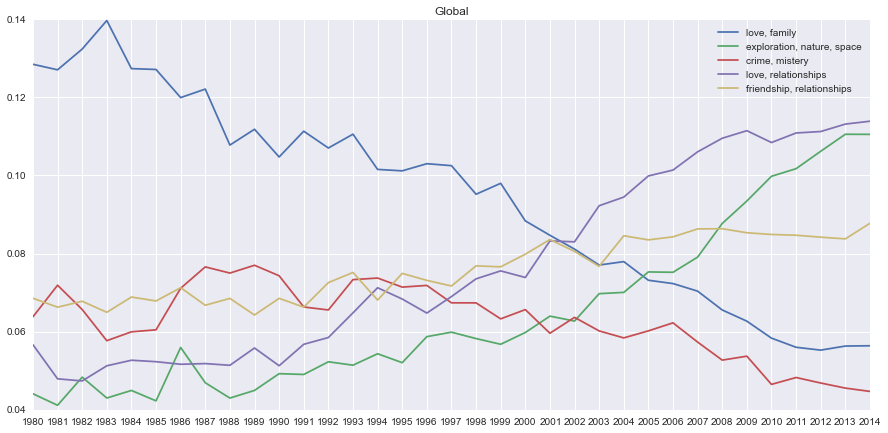

In [300]:
years = range(1980,2015)
imdb_topic_scores = get_topic_scores_year(imdb_topic_df, imdb_top_topics, years)
#set topic labels instead of keys
key2label(imdb_topic_scores)
timeseries(imdb_topic_scores, 'Global')

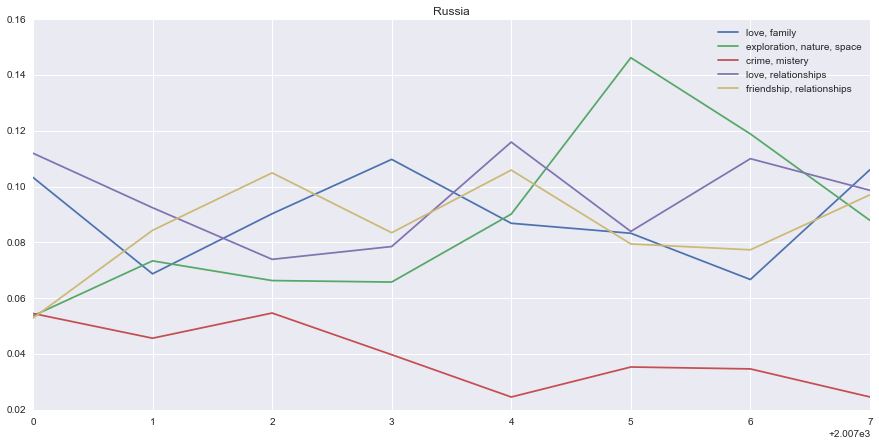

In [305]:
years = range(2007,2015)
topic_scores_year = get_topic_scores_year(get_origin(imdb_topic_df, origin='Russia'), imdb_top_topics, years)
key2label(topic_scores_year)
timeseries(topic_scores_year,'Russia')